In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input , Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Parámetros
IMG_HEIGHT = 256
IMG_WIDTH = 256
OUTPUT_CHANNELS = 1
LAMBDA = 100
EPOCHS = 30
BATCH_SIZE = 1

In [ ]:
def load_images_and_depth_maps(data_dir, input_shape, flip=True):
    images = []
    depth_maps = []

    folders = os.listdir(data_dir)

    for folder in folders:
        image_folder = os.path.join(data_dir, folder, "image")
        depth_map_folder = os.path.join(data_dir, folder, "groundtruth_depth")

        image_files = os.listdir(image_folder)
        depth_map_files = os.listdir(depth_map_folder)

        for image_file, depth_map_file in zip(image_files, depth_map_files):
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (input_shape[1], input_shape[0]))

            depth_map_path = os.path.join(depth_map_folder, depth_map_file)
            depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
            depth_map = cv2.resize(depth_map, (input_shape[1], input_shape[0]))

            images.append(image)
            depth_maps.append(depth_map)

            if flip:
                # Augment data by flipping horizontally
                flipped_image = cv2.flip(image, 1)
                flipped_depth_map = cv2.flip(depth_map, 1)
                images.append(flipped_image)
                depth_maps.append(flipped_depth_map)

    return np.array(images), np.array(depth_maps)

In [ ]:
data_dir = "/datos"
input_shape = (256, 256)
X, y = load_images_and_depth_maps(data_dir, input_shape, flip = False)

# Mostrar la forma de los datos aumentados
print("Shape of augmented X:", X.shape)
print("Shape of augmented Y:", y.shape)

Mounted at /content/drive
Shape of augmented X: (2000, 256, 256, 3)
Shape of augmented Y: (2000, 256, 256)


In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# para construir bloques del autoencoder
def convolucional(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result
# para la vgg16
def downsample_vgg16():
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    vgg16.trainable = False
    return vgg16

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        Conv2DTranspose(filters, size, strides=2,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def UNET():
    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    vgg16 = downsample_vgg16()

    # sacamos las salidas de la vgg
    block1_out = vgg16.layers[3].output
    block2_out = vgg16.layers[6].output
    block3_out = vgg16.layers[10].output
    block4_out = vgg16.layers[14].output
    block5_out = vgg16.layers[18].output

    # Upsampling layers
    up_stack = [
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                           padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    # para las skip connections de la unet
    x = vgg16(x)


    x = Concatenate()([x, block5_out])
    x = up_stack[0](x)
    x = Concatenate()([x, block4_out])
    x = up_stack[1](x)
    x = Concatenate()([x, block3_out])
    x = up_stack[2](x)
    x = Concatenate()([x, block2_out])
    x = up_stack[3](x)
    x = Concatenate()([x, block1_out])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

# para calcular la pérdida
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# para calcular la pérdida de la unet 
def unet_loss(gen_output, target):
    gan_loss = loss_object(tf.ones_like(gen_output), gen_output)
    #print("Shape of target:", target.shape)
    #print("Shape of gen_output:", gen_output.shape)
    if target.dtype != tf.float32:
        target = tf.cast(target, tf.float32)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

# usamos adam
unet_optimizer = tf.keras.optimizers.Adam(10e-4, beta_1=0.5)

unet = UNET()

In [ ]:
# para entrenar
def train(input, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # aplicamos la red
        gen_output = unet(input, training=True)
        gen_output = tf.squeeze(gen_output, axis=-1)
        # calculamos perdidas
        gen_loss = unet_loss(gen_output, target)
    # aplicamos descenso de gradiente
    unet_gradients = gen_tape.gradient(gen_loss, unet.trainable_variables)
    unet_optimizer.apply_gradients(zip(unet_gradients, unet.trainable_variables))
    # devolvemos las perdidas
    return gen_loss

def fit(xtrain, ytrain, epochs):
    train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
    train_ds = train_ds.batch(BATCH_SIZE).shuffle(len(xtrain))
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}")
        epoch_gen_loss = []
        for input, target in train_ds:
            l1= train(input, target)
            epoch_gen_loss.append(l1)
        print(f"unet Loss: {tf.reduce_mean(epoch_gen_loss)}")

In [ ]:
# entrenamos
fit(X_train, y_train, EPOCHS)


Epoch: 1/30
Generator Loss: 167.60284423828125, Discriminator Loss: 0.33738458156585693
Epoch: 2/30
Generator Loss: 168.43666076660156, Discriminator Loss: 0.11209414154291153
Epoch: 3/30
Generator Loss: 168.85093688964844, Discriminator Loss: 0.06820931285619736
Epoch: 4/30
Generator Loss: 168.6935577392578, Discriminator Loss: 0.06812358647584915
Epoch: 5/30
Generator Loss: 168.99447631835938, Discriminator Loss: 0.051138147711753845
Epoch: 6/30
Generator Loss: 168.08155822753906, Discriminator Loss: 0.05833110958337784
Epoch: 7/30
Generator Loss: 167.35992431640625, Discriminator Loss: 0.05286116153001785
Epoch: 8/30
Generator Loss: 167.7636260986328, Discriminator Loss: 0.044955309480428696
Epoch: 9/30
Generator Loss: 166.4449462890625, Discriminator Loss: 0.046192917972803116
Epoch: 10/30
Generator Loss: 166.07472229003906, Discriminator Loss: 0.033315304666757584
Epoch: 11/30
Generator Loss: 166.26058959960938, Discriminator Loss: 0.03677847236394882
Epoch: 12/30
Generator Loss: 

In [ ]:
# semilla para mostrar resultados aleatorios
np.random.seed(12345)

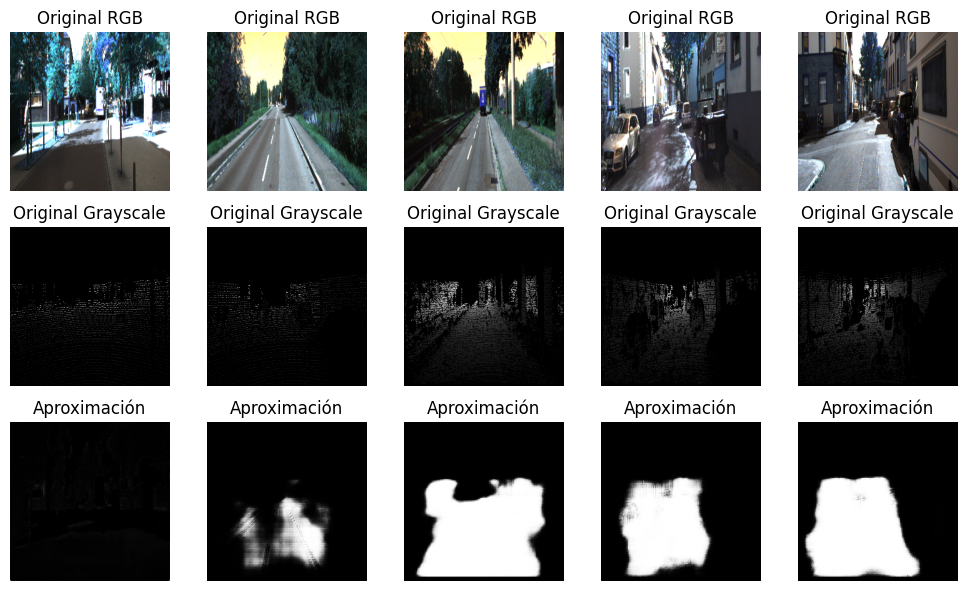

In [ ]:
# generar imágenes reconstruidas
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

# sacamos la muestra aleatoria
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_indices):
    input_image = X_test[idx:idx+1]
    target = y_test[idx:idx+1]

    # Imagen original en RGB
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(input_image[0])
    plt.title('Original RGB')
    plt.axis('off')

    # Imagen original en escala de grises
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(target[0], cmap='gray')
    plt.title('Original Grayscale')
    plt.axis('off')

    # Generar la imagen reconstruida
    gen_output = generator(input_image, training=False)

    # Imagen reconstruida
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(gen_output[0], cmap='gray')
    plt.title('Aproximación')
    plt.axis('off')

plt.tight_layout()
plt.show()
